In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
!pip install louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import seaborn as sns
import os 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import scvi
import scanpy as sc
import pandas as pd
np.random.seed(0)

In [5]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map='viridis')
sc.logging.print_header()
sc.settings.savefigs = False  

scanpy==1.8.2 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.2 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.8


In [6]:
Root_Folder = "/content/drive/MyDrive/Alethiomics"
os.chdir(Root_Folder)

In [7]:
#Dataset filenames
filename_data_da = './data/data_donor_a/matrix.mtx'
filename_genes_da = './data/data_donor_a/genes.tsv'
filename_barcodes_da = './data/data_donor_a/barcodes.tsv'

filename_GSE ='./data/GSE149938/GSE149938_umi_matrix.csv'

#_da is used to denote Frozen PBMC (Donor A)
#_GSE is used to denote GEO GSE149938

In [8]:
%%time
#Load Datasets
adata_da = sc.read(filename_data_da,cache=True).transpose()
adata_da.var_names = np.loadtxt(filename_genes_da, dtype=str)[:, 1]
adata_da.smp_names = np.loadtxt(filename_barcodes_da, dtype='S')
adata_GSE = sc.read(filename_GSE,cache=True)

sc.logging.print_memory_usage()

... reading from cache file cache/data-data_donor_a-matrix.h5ad
... reading from cache file cache/data-GSE149938-GSE149938_umi_matrix.h5ad
Memory usage: current 1.56 GB, difference +1.56 GB
CPU times: user 1.23 s, sys: 176 ms, total: 1.4 s
Wall time: 1.42 s


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
adata_da.layers["counts"] = adata_da.X
adata_GSE.layers["counts"] = adata_GSE.X

In [10]:
#We try to distinguish betweem mitochondrial, ribosomal and hemoglobin genes are expressed in datasets. 
#We might use them later in QC in case we detect anomalies. 

# mitochondrial genes for _da and _GSE
adata_da.var['mt'] = adata_da.var_names.str.startswith('MT-') 
adata_GSE.var['mt'] = adata_GSE.var_names.str.startswith('MT-') 
# ribosomal genes for _da and _GSE
adata_da.var['ribo'] = adata_da.var_names.str.startswith(("RPS","RPL"))
adata_GSE.var['ribo'] = adata_GSE.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes for _da and _GSE
adata_da.var['hb'] = adata_da.var_names.str.contains(("^HB[^(P)]"))
adata_GSE.var['hb'] = adata_GSE.var_names.str.contains(("^HB[^(P)]"))

In [11]:
#Estimate QC metrics for mt,ribo and hb genes along with rest of the data.
sc.pp.calculate_qc_metrics(adata_da, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata_GSE, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [12]:
#Filter out genes that are not exressed in any cell and normailze datasets

sc.pp.filter_genes(adata_da, min_cells = 1)
sc.pp.filter_genes(adata_GSE, min_cells = 1)

sc.pp.normalize_per_cell(adata_da)# normalize with total UMI count per cell
sc.pp.normalize_per_cell(adata_GSE)# normalize with total UMI count per cell

filtered out 17054 genes that are detected in less than 1 cells
filtered out 620 genes that are detected in less than 1 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
print('Since for _da there are cells with up to {:.2f}%, we will remove cells with more than {:.2f}% mitochondrial Rna'.format(np.max(adata_da.obs['pct_counts_mt']),5.0))
print('For _GSE all cells have {:.2f}% of mitochondrial Rna, so no filteringneeds to be done'.format(np.max(adata_GSE.obs['pct_counts_mt'])))

adata_da = adata_da[adata_da.obs['pct_counts_mt']<5.00001,:]

Since for _da there are cells with up to 20.88%, we will remove cells with more than 5.00% mitochondrial Rna
For _GSE all cells have 0.00% of mitochondrial Rna, so no filteringneeds to be done


In [14]:
#Keep genes with highest dispersion.
#As datasets have different number of genes with some experimentation we found tha 
#The top 2200 genes in _da and 4000 for _GSE yield similar levels of dispersion. 

filter_result_da = sc.pp.filter_genes_dispersion(adata_da.X, flavor='cell_ranger', n_top_genes=2200, log=False)
filter_result_GSE = sc.pp.filter_genes_dispersion(adata_GSE.X, flavor='cell_ranger', n_top_genes=4000, log=False)

sc.pp.filter_genes_dispersion(adata_da, flavor='cell_ranger', n_top_genes=2200, log=False)
sc.pp.filter_genes_dispersion(adata_GSE, flavor='cell_ranger', n_top_genes=4000, log=False)


extracting highly variable genes
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:129: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['means'] = result['means']
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:01)


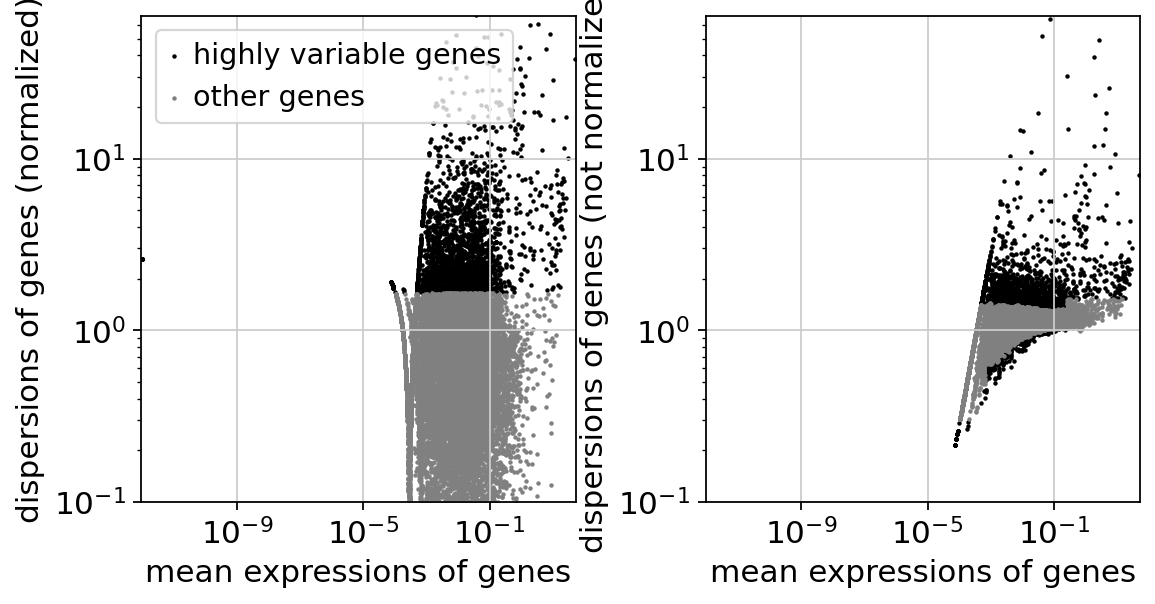

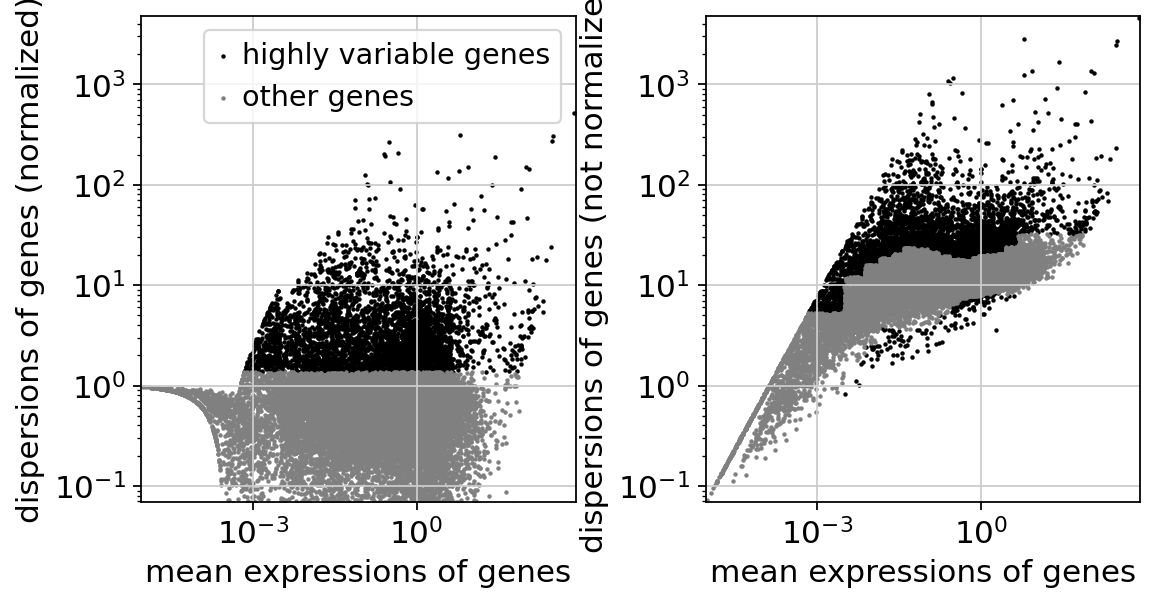

In [15]:
sc.pl.filter_genes_dispersion(filter_result_da, log=True)
sc.pl.filter_genes_dispersion(filter_result_GSE, log=True)

In [16]:
#Keep genes which appear in both datasets
var_names = adata_GSE.var_names.intersection(adata_da.var_names)
adata_GSE = adata_GSE[:, var_names]
adata_da = adata_da[:, var_names]

In [17]:
%%time
sc.pp.scale(adata_da) #scale _da data
sc.pp.scale(adata_GSE) #scale _gse data

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
CPU times: user 88.8 ms, sys: 2.88 ms, total: 91.7 ms
Wall time: 89.7 ms


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
# _GSE has more heterogeneity as it derived from 21 donors.
#Furthermore it easier to crosreference with cell type identification using gene markers which makes it easier to
#label cells in the _da cells where suck information is not available.
#Hence, we will use it as a reference genome.

In [19]:
#Estimating low dimensional embeddings with PCA and Umap for reference genome
sc.tl.pca(adata_GSE, n_comps=50,random_state=0)
sc.pp.neighbors(adata_GSE, n_neighbors=10, n_pcs=50,random_state=0)
sc.tl.umap(adata_GSE,random_state=0)
sc.logging.print_memory_usage()

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)
Memory usage: current 3.97 GB, difference +2.42 GB


In [20]:
#Louvain and Leiden clustering for reference genome
sc.tl.louvain(adata_GSE, resolution = 0.4, key_added = "louvain",random_state=0)
sc.tl.leiden(adata_GSE, resolution = 0.4, key_added = "leiden",random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


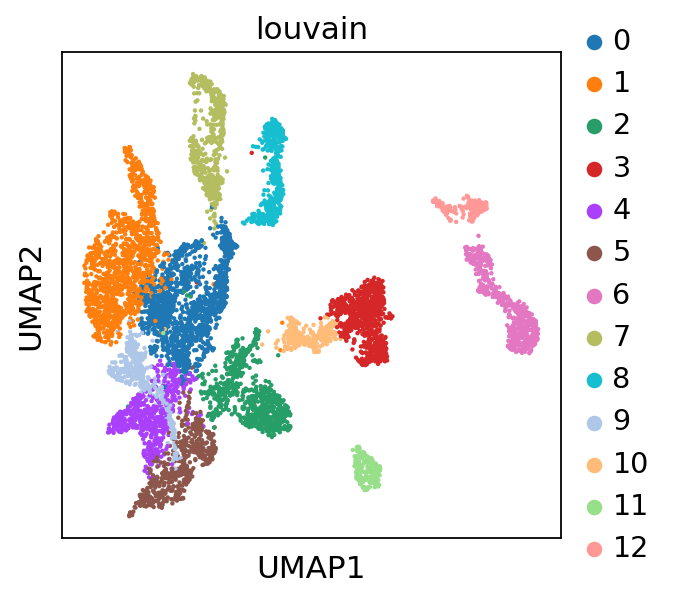

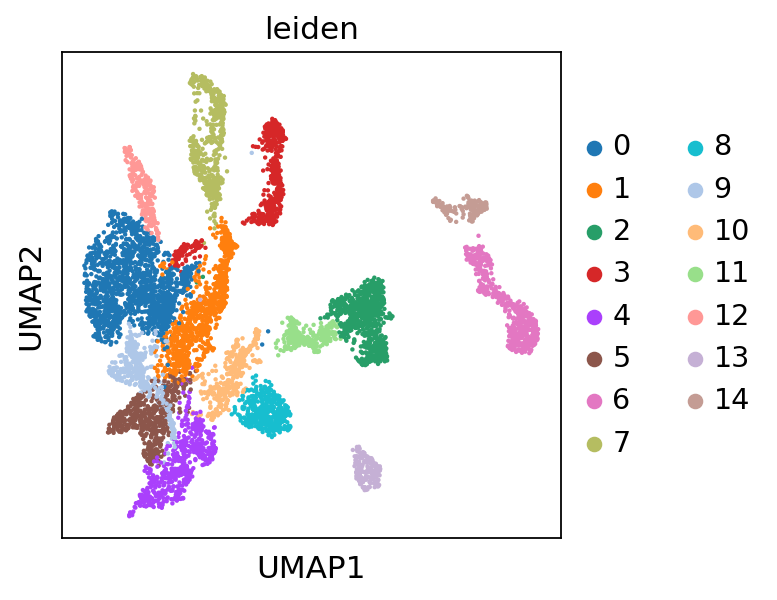

In [21]:
sc.pl.umap(adata_GSE,color=['louvain'])
sc.pl.umap(adata_GSE,color=['leiden'])

#As louvain and leiden find identical clusterin we going to use leiden clustering for integration.

In [22]:
#Map labels and embeddings from adata_GSE to adata_da.
sc.tl.ingest(adata_da, adata_GSE, obs='leiden')

running ingest
    finished (0:00:35)


In [23]:
#Fix cluster colors accross datasets
adata_da.uns['leiden'] = adata_GSE.uns['leiden']

In [24]:
#Concatenate adata_GSE with adata_da to create the integrated dataset
adata_concat = adata_GSE.concatenate(adata_da, batch_categories=['GSE', 'da'])

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
#Map leiden clusters to ground truth by investigate the frequency of leiden and ground truth labels
adata_GSE.obs['ground truth cell type'] = [str(ii).split('_')[0] for ii in adata_GSE.obs_names]
analytics = pd.DataFrame(adata_GSE.obs['leiden'])
analytics['ground truth cell type'] = pd.DataFrame(adata_GSE.obs['ground truth cell type'])

print(analytics.value_counts()[1:40])

cluster2annotation = {
     '0': 'Ery',
     '1': 'Progenitors-Mo',
     '2': 'B_cells',
     '3': 'Neutrophil',
     '4': 'HSC',
     '5': 'HSC',
     '6': 'T-cells',
     '7': 'Monocytes',
     '8': 'Progenitors',
     '9': 'Progenitors-Ery',
     '10': 'Progenitors',
     '11': 'Progenitors-B',
     '12': 'Ery',
     '13': 'Plasma',
     '14': 'NK'
}


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


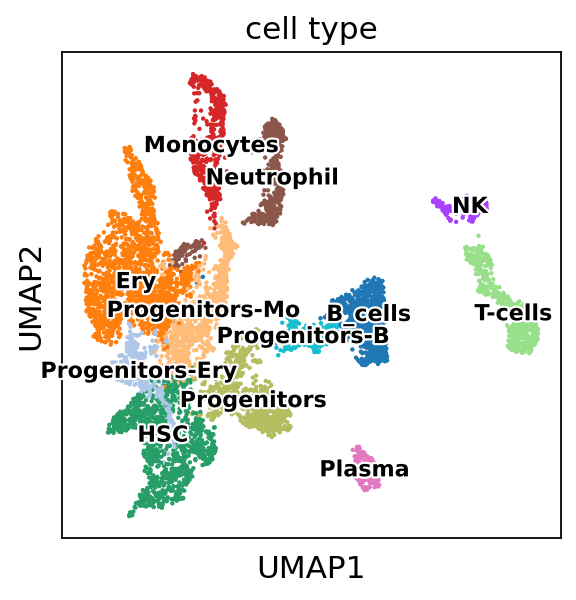

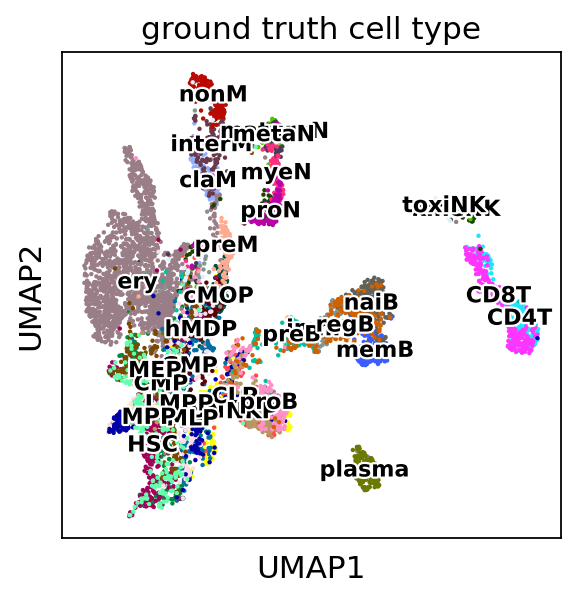

In [27]:
#Define cluster based on marker genes and compare with _GSE ground truth.

adata_concat.obs['cell type'] = adata_concat.obs['leiden'].map(cluster2annotation).astype('category')
adata_GSE.obs['cell type'] = adata_GSE.obs['leiden'].map(cluster2annotation).astype('category')
adata_GSE.obs['ground truth cell type'] = [str(ii).split('_')[0] for ii in adata_GSE.obs_names]

sc.pl.umap(adata_GSE, color='cell type', legend_loc='on data', legend_fontsize=10, legend_fontoutline=2)
sc.pl.umap(adata_GSE, color='ground truth cell type', legend_loc='on data', legend_fontsize=10, legend_fontoutline=2)


<ipython-input-28-94ed08904d9e>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.louvain.cat.reorder_categories(adata_GSE.obs.louvain.cat.categories, inplace=True)  # fix category ordering
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


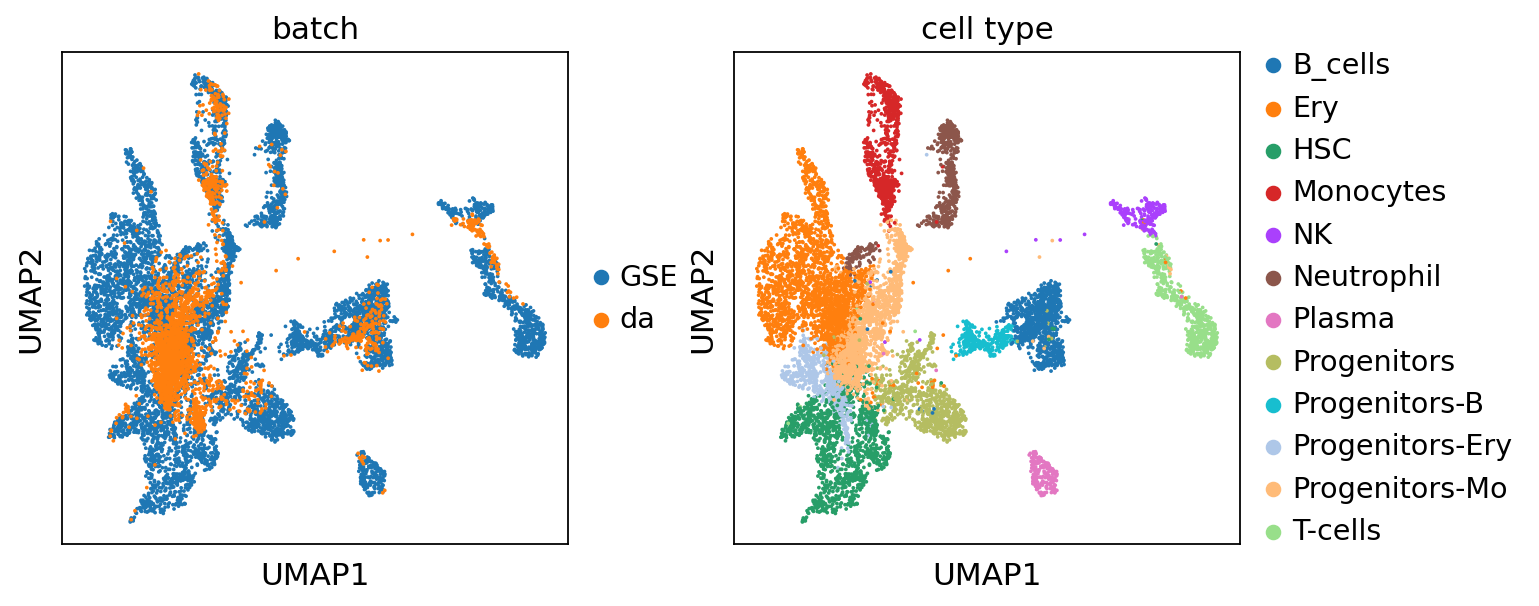

In [28]:
#Color-code latent space with batch and cell label to qualitatively inspect integration
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_GSE.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['leiden'] = adata_GSE.uns['leiden'] 
sc.pl.umap(adata_concat, color=['batch', 'cell type'])

# Lets Perform Integration using scVI and scANVI from scvi tools

In [31]:
# Import adata_concat into scvi model
scvi.model.SCVI.setup_anndata(adata_concat, layer="counts", batch_key='batch')

In [32]:
#Set scvi network architecture
vae = scvi.model.SCVI(adata_concat, n_layers=2, n_latent=20,gene_likelihood='zinb')

In [33]:
#Train scvi for 250 epochs
vae.train(max_epochs=250)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30/30: 100%|██████████| 30/30 [00:29<00:00,  1.23it/s, loss=640, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [00:29<00:00,  1.00it/s, loss=640, v_num=1]


In [34]:
#Add latent scvi representation in adata_concat
adata_concat.obsm["X_scVI"] = vae.get_latent_representation()

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


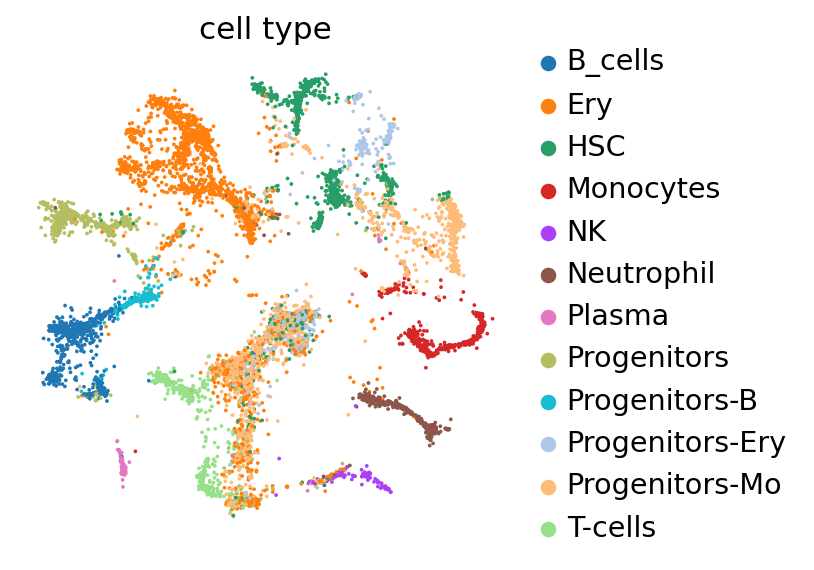

In [35]:
#Plot scVI's ground truth
from scvi.model.utils import mde

adata_concat.obsm["X_mde"] = mde(adata_concat.obsm["X_scVI"])
sc.pl.embedding(adata_concat, basis="X_mde", color=["cell type"],frameon=False,ncols=1)

In [37]:
#Mask _da dataset labels to idenitfy them with scANVI
adata_concat.obs["celltype_scanvi"] = 'Unknown'
GSE_mask = adata_concat.obs['batch'] == "GSE"
adata_concat.obs["celltype_scanvi"][GSE_mask] = adata_concat.obs['cell type'][GSE_mask].values


<ipython-input-37-2bcaa691c6c0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_concat.obs["celltype_scanvi"][GSE_mask] = adata_concat.obs['cell type'][GSE_mask].values


In [38]:
#Define scANVI model
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_concat,
    unlabeled_category="Unknown",
    labels_key="celltype_scanvi",
    gene_likelihood = "nb"
)

/usr/local/lib/python3.8/dist-packages/scvi/model/_scanvi.py:199: UserWarning: Ignoring param 'gene_likelihood' as it was already passed in to pretrained scvi model with value zinb.
  warnings.warn(


In [39]:
#Train scANVI fro 30 epochs
lvae.train(max_epochs=30)

INFO     Training for 30 epochs.                                                                                   


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30/30: 100%|██████████| 30/30 [00:52<00:00,  1.73s/it, loss=714, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [00:52<00:00,  1.75s/it, loss=714, v_num=1]


In [40]:
#Add latent scvi representation in adata_concat
adata_concat.obs["C_scANVI"] = lvae.predict(adata_concat)
adata_concat.obsm["X_scANVI"] = lvae.get_latent_representation(adata_concat)

In [41]:
adata_concat.obsm["X_mde_scanvi"] = mde(adata_concat.obsm["X_scANVI"])

In [42]:
adata_concat.obs.C_scANVI = pd.Categorical(
    adata_concat.obs.C_scANVI.values,
    categories=adata_concat.obs['cell type'].cat.categories
)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


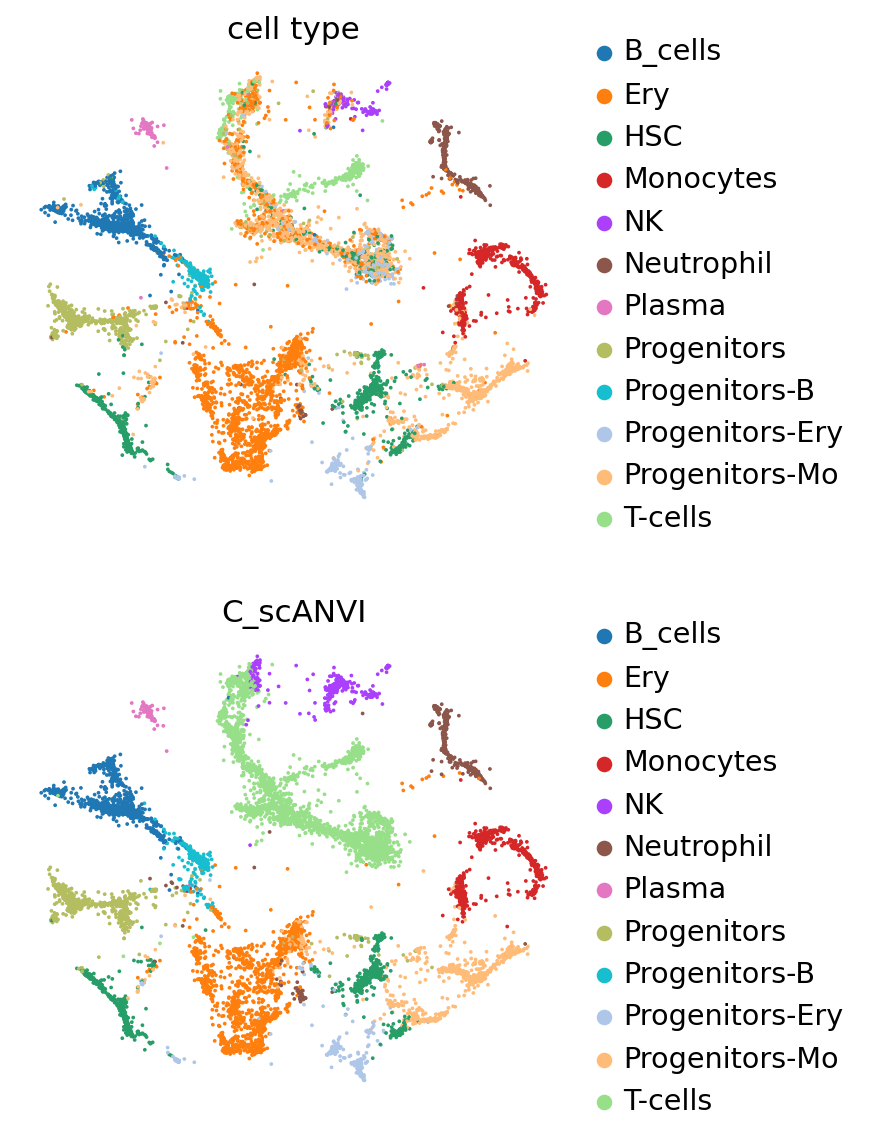

In [43]:
#Plot latent embedding  for ground truth and predicted labels
sc.pl.embedding(
    adata_concat,
    basis="X_mde_scanvi",
    color=[
           "cell type",
           "C_scANVI"
    ],
    ncols=1,
    frameon=False,
    palette=adata_concat.uns["cell type_colors"],
)

In [44]:
df = adata_concat.obs.groupby(["cell type", "C_scANVI"]).size().unstack(fill_value=0)

In [45]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

<ipython-input-46-ef78f14c4ece>:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.pcolor(conf_mat)


Text(0, 0.5, 'Observed')

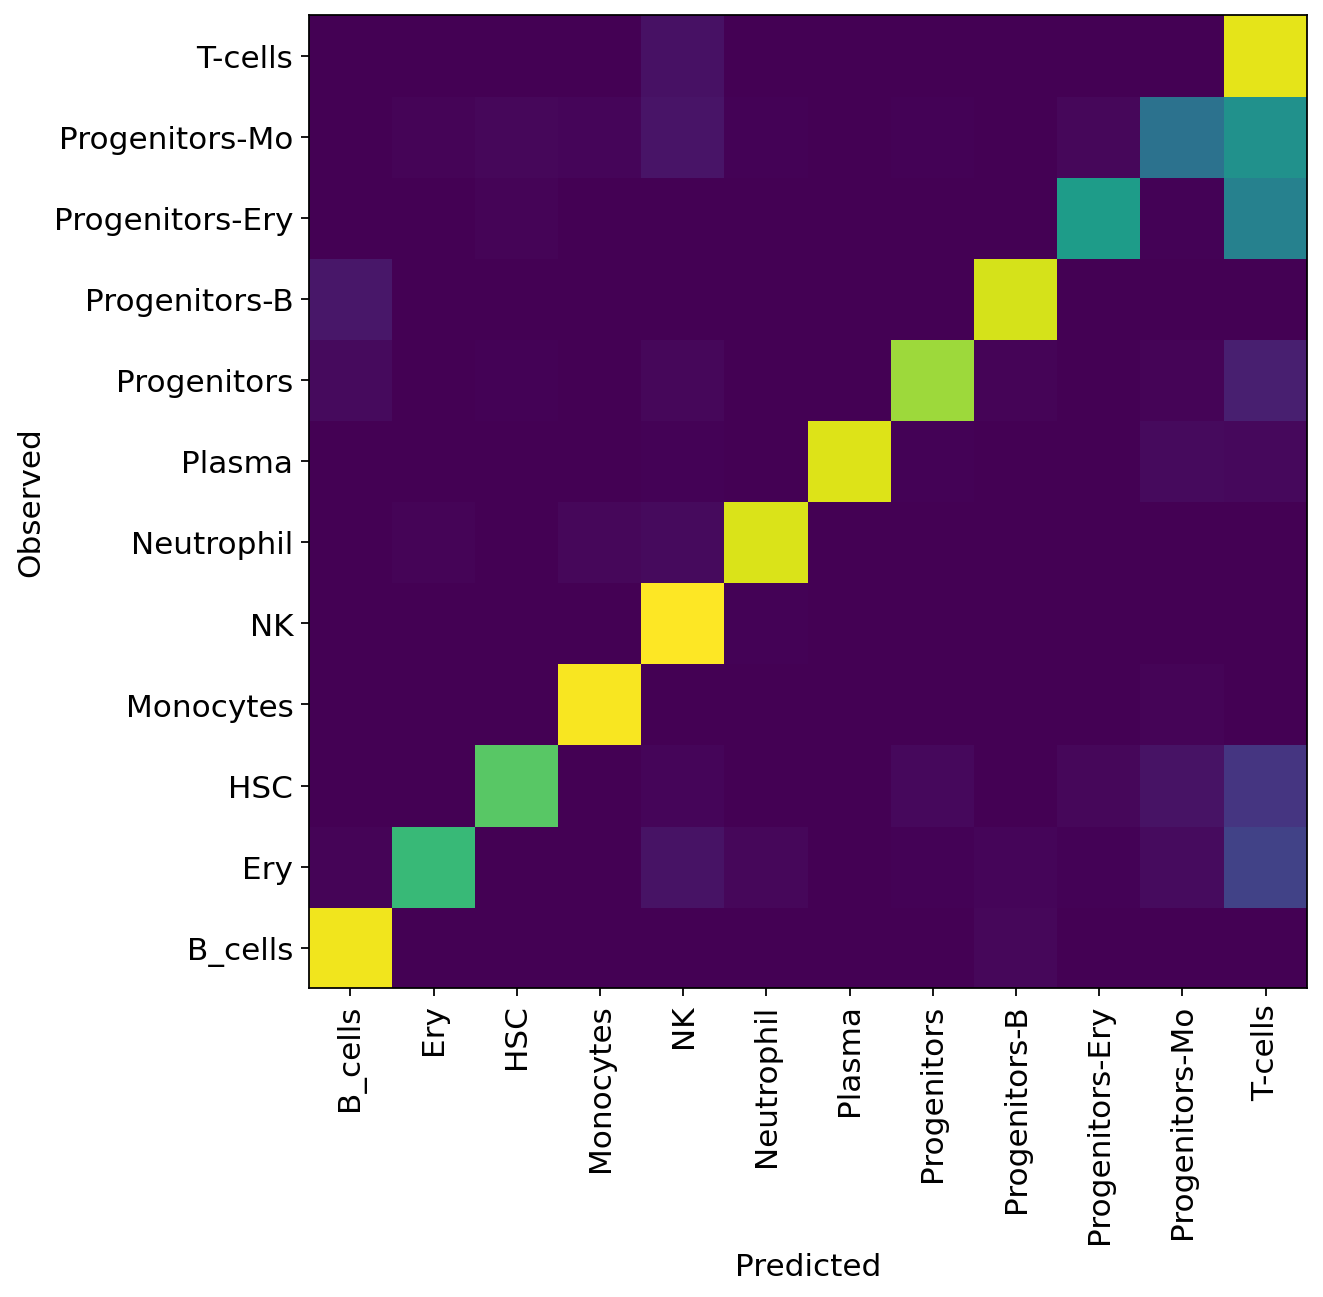

In [46]:
#Plot heatmap of observed labels as a function of predicted
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")